In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("Gemini_1INCHUSD_1h.csv", index_col = ['date'], parse_dates = True)
df = df[['open', 'high', 'low', 'close', 'Volume 1INCH', 'Volume USD']]
df.head(n=5)

,open,high,low,close,Volume 1INCH,Volume USD
date,,,,,,
2022-04-27 00:00:00,1.2871,1.2932,1.2865,1.2888,428.840257,552.689323
2022-04-26 23:00:00,1.2968,1.2970,1.2589,1.2871,1189.529669,1531.043637
2022-04-26 22:00:00,1.3093,1.3124,1.2961,1.2968,1281.291941,1661.579389
2022-04-26 21:00:00,1.2981,1.3116,1.2959,1.3093,2868.856831,3756.194249
2022-04-26 20:00:00,1.3053,1.3095,1.2900,1.2981,2084.128819,2705.407620


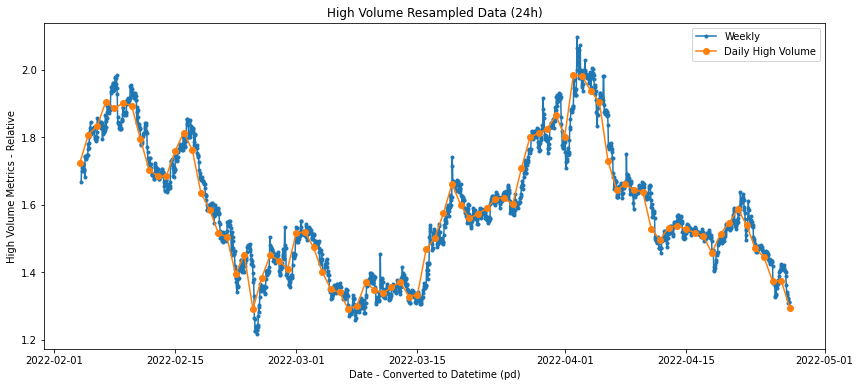

In [3]:
'''
Plotting the Data of High Volumes for 1INCH DAOS
'''

y = df['high']
fig, ax = plt.subplots(figsize = (14, 6))
ax.plot(y, marker = '.', linestyle = '-', label = 'Weekly')
ax.plot(y.resample('D').mean(), marker = 'o', linestyle = '-', label = "Daily High Volume")
#ax.plot(y.resample('M').mean(), marker = 'o', linestyle = '-', label = "Monthly High Volume")
#ax.plot(y.resample('Y').mean(), marker = 'o', linestyle = '-', label = "Yearly High Volume")
ax.set_xlabel("Date - Converted to Datetime (pd)")
ax.set_ylabel("High Volume Metrics - Relative")
ax.set_title("High Volume Resampled Data (24h)")
ax.legend()

<AxesSubplot:xlabel='date'>

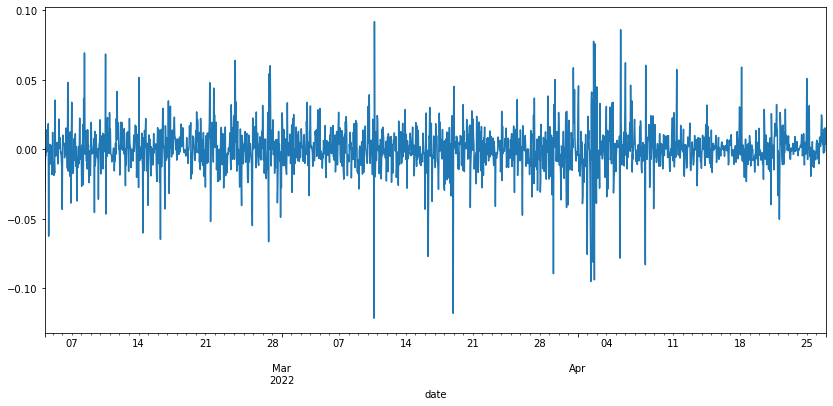

In [4]:
'''
First Difference Applied
-> Make the Data Stationary by applying first difference of the Series
subtract prev_value by t-1 to get d(t)
'''
df['First Diff Shift'] = df['high'] - df['high'].shift(1)
df['First Diff Shift'].plot(figsize = (14,6))

<AxesSubplot:xlabel='date'>

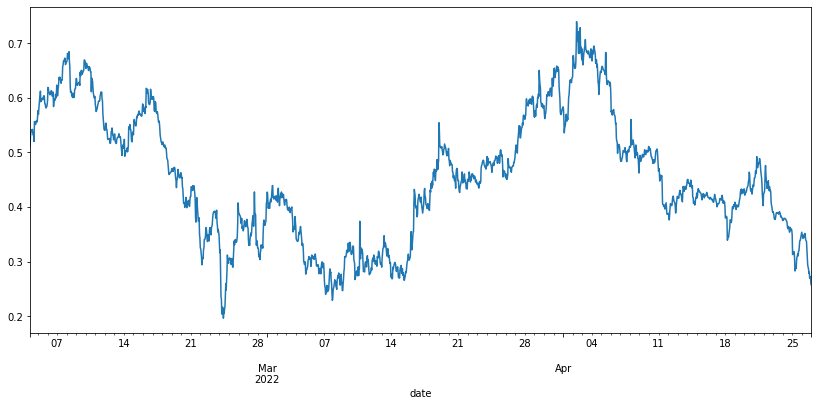

In [5]:
'''
Log Difference 
-> Transform to original series
'''
df['Log Difference'] = df['high'].apply(lambda x: np.log(x))
df['Log Difference'].plot(figsize = (14, 6))

<AxesSubplot:title={'center':'Log Variance'}, xlabel='date'>

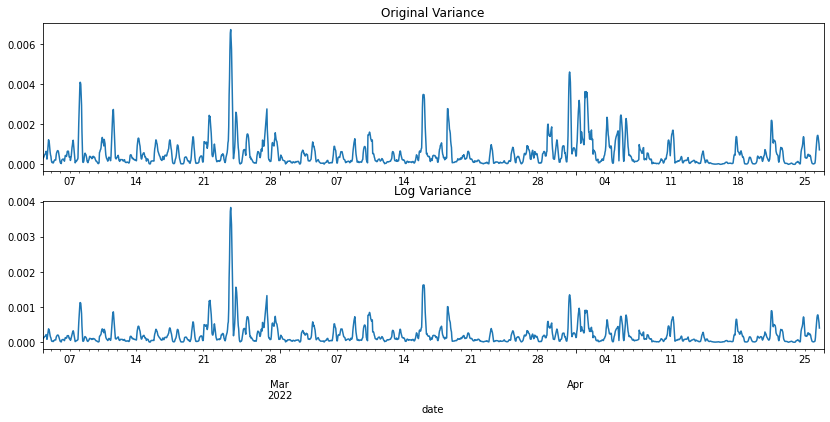

In [6]:
df['Original Variance'] = pd.Series(df['high']).rolling(window = 12).var()
df['Log Variance'] = pd.Series(df['Log Difference']).rolling(window = 12).var()
fig, ax = plt.subplots(2, 1, figsize = (14,6))
df['Original Variance'].plot(ax = ax[0], title = 'Original Variance')
df['Log Variance'].plot(ax = ax[1], title = 'Log Variance') 

<AxesSubplot:xlabel='date'>

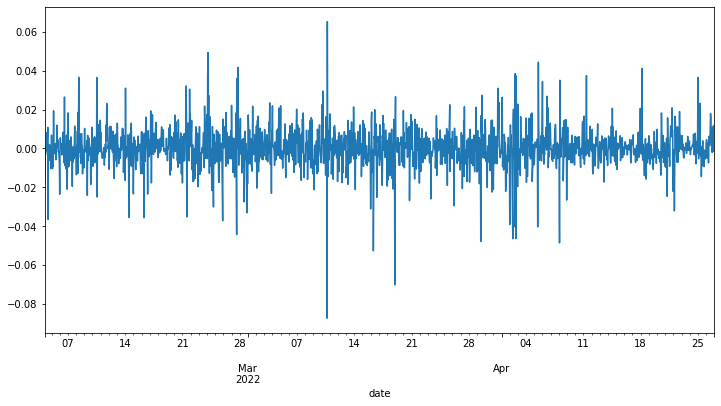

In [7]:
df['Log First Difference'] = df['Log Difference'] - df['Log Difference'].shift()
df['Log First Difference'].plot(figsize = (12, 6))

<AxesSubplot:title={'center':'Lag 30'}, xlabel='date'>

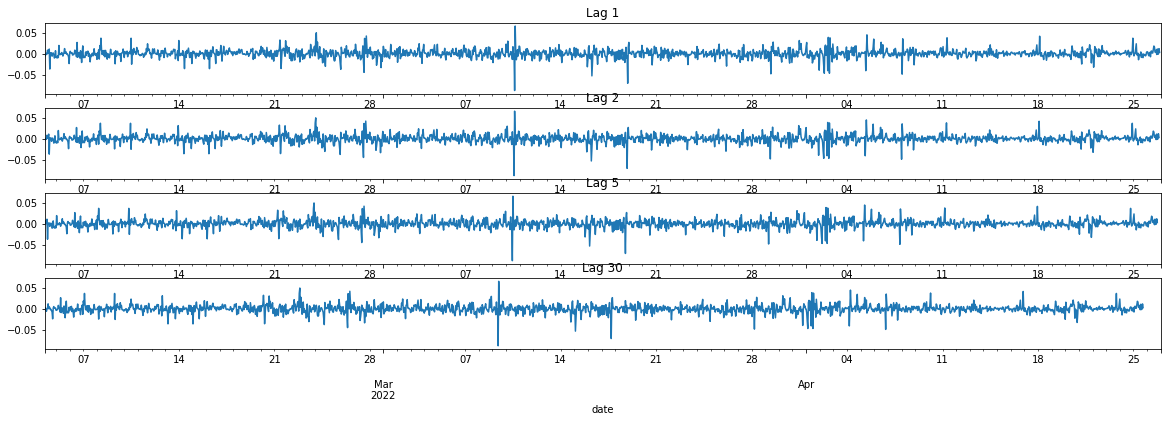

In [8]:
'''
1 and 2 day lags, and weekly and monthly lags 
Looking for Seasonal Effects in the data
'''
df['Lag 1'] = df['Log First Difference'].shift()
df['Lag 2'] = df['Log First Difference'].shift(2)
df['Lag 5'] = df['Log First Difference'].shift(5)
df['Lag 30'] = df['Log First Difference'].shift(30)

fig, ax = plt.subplots(4, 1, figsize = (20, 6))
df['Lag 1'].plot(ax = ax[0], title = "Lag 1")
df['Lag 2'].plot(ax = ax[1], title = "Lag 2")
df['Lag 5'].plot(ax = ax[2], title = "Lag 5")
df['Lag 30'].plot(ax = ax[3], title = "Lag 30")

C:\Users\kzhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\kzhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


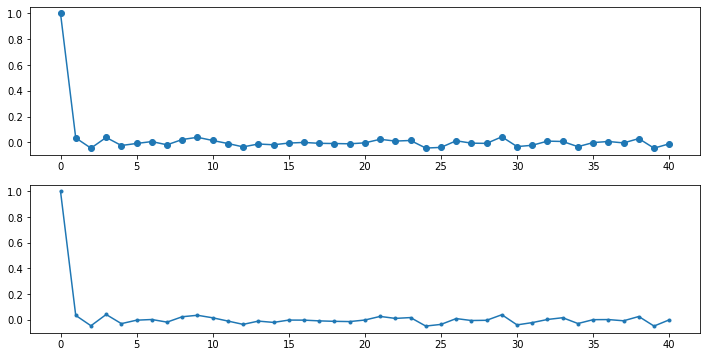

In [9]:
'''
An ACF measures and plots the average correlation between data points in a time series and previous values of the series measured for different lag lengths. 
A PACF is similar to an ACF except that each partial correlation controls for any correlation between observations of a shorter lag length.
'''

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(df['Log First Difference'].iloc[1:], fft = False)
lag_partial_correlations = pacf(df['Log First Difference'].iloc[1:])

fig, ax = plt.subplots(2, 1, figsize = (12, 6))
ax[0].plot(lag_correlations, marker = 'o', linestyle = '-')
ax[1].plot(lag_partial_correlations, marker = '.', linestyle = '-')

C:\Users\kzhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\kzhan\AppData\Local\Packages\PythonSoftwareFoundation.Pytho

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         Log Difference   No. Observations:                 1964
Model:                     ARMA(1, 0)   Log Likelihood                6265.848
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sat, 21 May 2022   AIC                         -12525.697
Time:                        00:21:32   BIC                         -12508.948
Sample:                             0   HQIC                        -12519.541
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4387      0.058      7.591      0.000       0.325       0.552
ar.L1.Log Difference     0.9966      0.002    557.221      0.000       0.993       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0034           +0.0000j            1.0034            0.0000
-----------------------------------------------------------------------------
"""

<Figure size 1440x432 with 0 Axes>

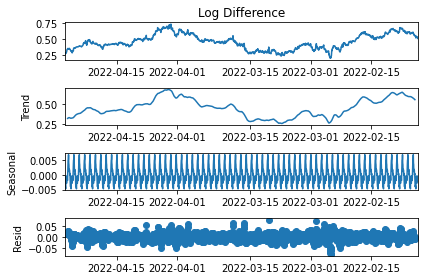

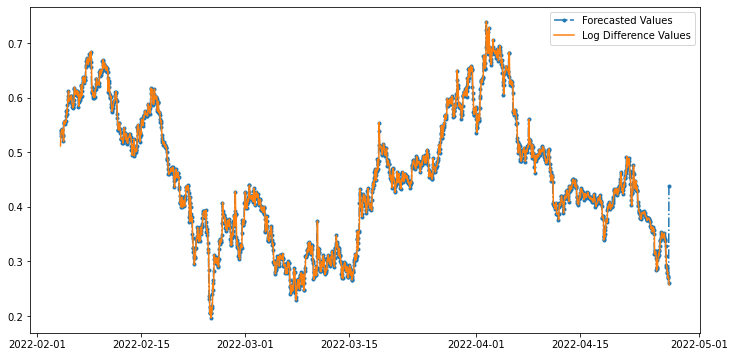

In [38]:
'''
Decomposition Method - Breakdown Time Series into trend, seasonal, and residual factors
There are three clearly distinct components to the time series - a trend line, a seasonal adjustment, and residual values. 
Each of these would need to be accounted for and modeled appropriately.
'''
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

'''
#Or We can define a separate function to decompose the data
def seasonal_decompose(y_values, model, freq):
    decomposition = seasonal_decompose(y_values, model = model, freq = freq)
    fig = plt.figure(figsize = (20, 6))
    fig.decomposition.plot()

#Define function for external use cases of ARIMA Autoreg Alg
def create_ARIMA(y_values, order):
    model = sm.tsa.ARIMA(y_values.iloc[1:], order = order)
    results = model.fit(display = -1)
    y_values = results.fittedvalues
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(y_values, marker = '.', linestyle = '-', label = 'Forecasted Values')
    ax.plot(y_values, linestyle = '-', label = "Log Difference")
    ax.legend()
'''

decomp = seasonal_decompose(df['Log Difference'], model = 'additive', period = 30)
fig = plt.figure(figsize = (20,6))
fig = decomp.plot()

model = sm.tsa.ARIMA(df['Log Difference'].iloc[1:], order = (1, 0, 0))
results = model.fit(display = -1)
df['Forecast'] = results.fittedvalues
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(df['Forecast'], marker = '.', linestyle = '-.', label = 'Forecasted Values')
ax.plot(df['Log Difference'], linestyle = '-', label = "Log Difference Values")
ax.legend()

results.summary()